In [1]:
import pandas as pd
import numpy as np
import copy
import datetime
import time

In [ ]:
marvin = './data/rttm/mar_tz_swahili.rttm'
dihard = './data/rttm/dih_tz_swahili.rttm'

In [13]:
!pwd

/Users/tsslade/projects/w210_capstone/teacherprints


### RTTM to Dataframe

In [3]:
# Step 1: Load the .rttm into a dataframe
def DfFromRttm(rttm):
    """ Given an RTTM file, parses it into a Pandas DataFrame.
    """
    df = pd.read_csv(rttm,
                     sep=' ',
                     names=['task','inputFile','one','start','duration',
                     'NA_1','NA_2','class','NA_3', 'NA_4'])    
    
    # Drop the columns we don't care about from a base RTTM
    vizframe = copy.deepcopy(df) \
        .drop(
        columns=[
            'task',
            'inputFile',
            'one',
            'NA_1',
            'NA_2',
            'NA_3',
            'NA_4'])
    
    return vizframe

## Audiozation Data

In [4]:
def RttmToUtteranceIndexedSpeakerActivity(df, outfile=None):
    """ Given an RTTM input file, generate a dataframe structured
        to support a visualization of type 'Speaker Activity' and optionally
        export to a csv located at {outfile}

        df = Pandas DataFrame containing a standard .rttm file
        outfile = destination for exported CSV (path, filename, extension)
    """

    # Check whether an outfile has been defined
    if outfile is not None:
        export = True
    else: 
        export = False

    # Drop the columns we don't care about from a base RTTM
    vizframe = copy.deepcopy(df) 

    # Rename columns for our viz's purposes
    vizframe = vizframe.rename(columns={
        'start': 'START',
        'duration': 'DUR',
        'class': 'LABEL'
    })

    # Remap the model classes for this viz's purposes
    vizframe['LABEL'] = vizframe['LABEL'].map({
        'KCHI': 'CHILD',
        'CHI': 'CHILD',
        'FEM': 'ADULT',
        'MAL': 'ADULT'
    })

    # Filter the dataframe to just the 'clean' (non-'SPEECH') classes
    vizframe = vizframe[vizframe['LABEL'].isin(['CHILD', 'ADULT'])]
    vizframe['LABEL_NUM'] = vizframe['LABEL'] \
        .apply(lambda x: 1 if x == 'CHILD'
               else (-1 if x == 'ADULT' else NaN))
    vizframe['DUR_TRANS'] = vizframe['LABEL_NUM'] * vizframe['DUR']
    vizframe['COUNT'] = 1

    if export:
        vizframe.to_csv(outfile)

    return vizframe

## Time-Indexed Dataframe

In [5]:
## Identify the latest timestamp we need.
def GetLatestTimestampNeeded(input_df, verbose=True):
    """ Given an RTTM-derived dataframe,
        extract the last timestamp we'll need
        as a scalar. It will be the maximum value of
        the `start` + `duration` columns.
    """
    input_df['end_time'] = input_df['start'] + input_df['duration']
    end_row = input_df['end_time'].idxmax()
    latest_timestamp = input_df.at[end_row,'start'] + input_df.at[end_row,'duration']
    if verbose:
        print(f'''
        >> This DF has data that runs until {latest_timestamp}.
        >> That value was found at row {end_row} and is the sum of
           {input_df.at[end_row, 'start']} and {input_df.at[end_row, 'duration']}
        ''')
    return latest_timestamp

In [6]:
## Create millisecond index.
def MakeMillisecondIntegerIndexedDf(
        start,
        duration,
        colname='value',
        colvalue='',
        decimals=4,
        verbose=False):
    """ Create an integer-indexed dataframe covering a 
            {duration} from
            {start} having a single column with the name
            {colname} that contains a default value of
            {colvalue} for that named column.
        By default it runs quietly rather than {verbose}.
    """

    if verbose:
        print(f' >>> From [{start}] for [{duration}] seconds' \
              f' until [{start+duration}] the col [{colname}]' \
              f' will contain the value [{colvalue}]')
    
    # Create a range between the start and stop
    rng = pd.RangeIndex(start = int(round(start, decimals)*1000),
                        stop  = int(round(start+duration, decimals)*1000),
                        step  = 1)
    
    # Turn that series into a DataFrame and rename the index for clarity
    df = pd.Series(colvalue, index=rng).to_frame(name=colname)
    df.index.name=f'millisecond_ints'
    if verbose:
        print(df.head(3), df.tail(3))
    return df

In [7]:
## Subset by label.
def SubsetDfByLabel(df, column_list, key_col, value):
    """ Given a dataframe {df}, return the subset
        of the dataframe defined by {column_list}
        containing {value} in the {key_col} column
    """
    return df[df[key_col] == value][[x for x in column_list]]

In [8]:
def BuildOneHotEncodedDf(
    input_df,
    label_list=[],
    verbose=True
    ):
    """ Given an RTTM-generated DataFrame, generate a DF containing
        all of the labels of interest in one-hot encoded format
        against an integer-indexed DF representing milliseconds from
        the beginning of the recording
    """
    
    max_seconds_needed = GetLatestTimestampNeeded(input_df)
    if verbose:
        print(f'max_seconds_needed is equal to {max_seconds_needed}')

    outer_df = MakeMillisecondIntegerIndexedDf(
                start      = 0,
                duration   = max_seconds_needed,
                colname    = 'base_col',
                colvalue   = np.nan,
                decimals   = 4,
                verbose    = True)

    if verbose:
        print(f'The outer_df frame will contain {outer_df.shape[0]} records.')
    
    # Loop through labels, subsetting the original DF so
    # we can merge it back into the main outer DF
    for label in label_list:
        print(f'>>> Processing label: {label}\n')

        if label not in input_df['class'].unique():
            print(f'Label {label} not found in this dataset')
            label_base_df = pd.DataFrame(columns=[label])
            continue
        
        # Gotta avoid errors from accidentally manipulating original DFs
        temp_df = copy.deepcopy(input_df)

        # Replace the deep-copied DF with a subset of itself
        # that contains only records for the label of interest
        temp_df = SubsetDfByLabel(
            input_df,
            column_list = ['start', 'duration', 'class'],
            key_col     = 'class',
            value       = label
        )

        if verbose:
            print(f'The temp_df subset for label {label}' \
                  f' contains {temp_df.shape[0]} rows')
            print(temp_df.head(5),
                  temp_df.tail(5))
        
        # The subsetted DF retains the original index unless you reset it
        temp_df.reset_index(drop=True,
                            inplace=True)
        
        if verbose:
            print(f'The temp_df frame is as follows:\n{temp_df}')

        # Creating the base DF for this label - ranges from 0 to the earliest record
        label_base_df = MakeMillisecondIntegerIndexedDf(
                start      = 0,
                duration   = temp_df['start'].min(),
                colname    = label,
                colvalue   = np.nan,
                decimals   = 4,
                verbose    = verbose)
        
        if verbose:
            # The head() will always be the same, so we need to look at the tail() to verify
            print('\n>>> The last few rows of the label_base_df for label' \
                  f' {label} are:\n{label_base_df.tail()}' \
                  f'\n>>> Base DF size for label {label}: {len(temp_df)}\n')

        for i in temp_df.index:
            if verbose:
                print('*' * 10 + f'{label}: i = {i}' + '*' * 10)
            s, d, cn = temp_df.loc[i, ['start', 'duration', 'class']]
            label_base_df = label_base_df.append(
                MakeMillisecondIntegerIndexedDf(
                    start    = s,
                    duration = d,
                    colname  = cn,
                    colvalue = 1,
                    decimals = 4,
                    verbose  = verbose
                ))
            
            if verbose:
                print(f'\n>>> Base DF size after {i}' \
                      ' rounds: {len(label_base_df)}')
                print(f'\n>>> The head:\n{label_base_df.head(10)}'\
                      f'\n>>> The tail:\n{label_base_df.tail(10)}')
                print('\n>>> A few of its contents:'\
                      f'\n{label_base_df[~label_base_df[label].isna()].head(5)}')

        # Creating a placeholder for the update call
        outer_df[label] = np.nan
        
        # When attempting the update method:
        print(f'Attempting update with DF from label {label}')
        outer_df.update(
            other     = label_base_df,
            overwrite = True)
        
        if verbose:
            try:
                print(outer_df[~outer_df[label].isna()].head())
            except:
                print(outer_df)
            
    return outer_df

In [9]:
labels = ['MAL', 'CHI', 'KCHI', 'FEM', 'SPEECH']

In [12]:
marvin_df = BuildOneHotEncodedDf(DfFromRttm(marvin), label_list=labels, verbose=True)

FileNotFoundError: [Errno 2] File ./data/rttm/mar_tz_swahili.rttm does not exist: './data/rttm/mar_tz_swahili.rttm'

In [ ]:
marvin_df.head(20)

In [14]:
dihard_df = BuildOneHotEncodedDf(dihard, label_list=labels, verbose=True)

,base_col,MAL,CHI,KCHI,FEM,SPEECH
millisecond_ints,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
result.tail(20)

,base_col,MAL,CHI,KCHI,FEM,SPEECH
millisecond_ints,,,,,,
1266368,NaN,NaN,NaN,NaN,NaN,1.0
1266369,NaN,NaN,NaN,NaN,NaN,1.0
1266370,NaN,NaN,NaN,NaN,NaN,1.0
1266371,NaN,NaN,NaN,NaN,NaN,1.0
1266372,NaN,NaN,NaN,NaN,NaN,1.0
1266373,NaN,NaN,NaN,NaN,NaN,1.0
1266374,NaN,NaN,NaN,NaN,NaN,1.0
1266375,NaN,NaN,NaN,NaN,NaN,1.0
1266376,NaN,NaN,NaN,NaN,NaN,1.0


In [17]:
result.loc[495000:495050,]

,base_col,MAL,CHI,KCHI,FEM,SPEECH
millisecond_ints,,,,,,
495000,NaN,NaN,1.0,NaN,NaN,1.0
495001,NaN,NaN,1.0,NaN,NaN,1.0
495002,NaN,NaN,1.0,NaN,NaN,1.0
495003,NaN,NaN,1.0,NaN,NaN,1.0
495004,NaN,NaN,1.0,NaN,NaN,1.0
495005,NaN,NaN,1.0,NaN,NaN,1.0
495006,NaN,NaN,1.0,NaN,NaN,1.0
495007,NaN,NaN,1.0,NaN,NaN,1.0
495008,NaN,NaN,1.0,NaN,NaN,1.0


In [18]:
result.describe()

,base_col,MAL,CHI,KCHI,FEM,SPEECH
count,0.0,24879.0,119178.0,17134.0,930319.0,1106545.0
mean,NaN,1.0,1.0,1.0,1.0,1.0
std,NaN,0.0,0.0,0.0,0.0,0.0
min,NaN,1.0,1.0,1.0,1.0,1.0
25%,NaN,1.0,1.0,1.0,1.0,1.0
50%,NaN,1.0,1.0,1.0,1.0,1.0
75%,NaN,1.0,1.0,1.0,1.0,1.0
max,NaN,1.0,1.0,1.0,1.0,1.0


In [19]:
result.shape

(1266388, 6)

### Data Cleanup

In [20]:
# Drop base_col and SPEECH columns
result = result.drop(['base_col', 'SPEECH'], axis=1).fillna(0)

In [21]:
# Combine MAL/FEM and KCHI/CHI
result['ADULT'] = result.apply(lambda x: 0 if (x['MAL']==0 and x['FEM']==0) else 1, axis=1)
result['CHILD'] = result.apply(lambda x: 0 if (x['KCHI']==0 and x['CHI']==0) else 1, axis=1)

In [22]:
# Drop MAL/FEM and KCHI/CHI columns
result = result.drop(['MAL', 'CHI', 'KCHI', 'FEM'], axis=1)

In [23]:
# Combine ADULT and CHILD columns
result['SPEECH'] = result.apply(lambda x: 0 if (x['ADULT']==0 and x['CHILD']==0) else 1, axis=1)

In [ ]:
# Smooth data by eliminating pauses less than back_window + forward_window 
# milliseconds between consecutive statements.

back_window = 500
forward_window = 500

adult_window_back = result['ADULT'].rolling(back_window).sum()
adult_window_for = result['ADULT'].iloc[::-1].rolling(forward_window).sum()

child_window_back = result['CHILD'].rolling(back_window).sum()
child_window_for = result['CHILD'].iloc[::-1].rolling(forward_window).sum()

result['SMOOTH_A'] = np.where((adult_window_back >= 1) & (adult_window_for >= 1), 1, 0)
result['SMOOTH_C'] = np.where((child_window_back >= 1) & (child_window_for >= 1), 1, 0)

In [ ]:
# Combine SMOOTH_A and SMOOTH_C columns
result['SMOOTH_S'] = result.apply(lambda x: 0 if (x['SMOOTH_A']==0 and x['SMOOTH_C']==0) else 1, axis=1)

In [24]:
result.loc[495000:495050,]

,ADULT,CHILD,SPEECH
millisecond_ints,,,
495000,0,1,1
495001,0,1,1
495002,0,1,1
495003,0,1,1
495004,0,1,1
495005,0,1,1
495006,0,1,1
495007,0,1,1
495008,0,1,1


### Calculated Variables

In [25]:
# Identify overlaps and pauses.
result['OVERLAP'] = np.where(result[['ADULT', 'CHILD']].sum(axis = 1) == 2, 1, 0)
result['PAUSE'] = np.where(result[['ADULT', 'CHILD']].sum(axis = 1) == 0, 1, 0)

In [ ]:
# Identify overlaps and pauses based on smoothed data.
result['SMOOTH_OVERLAP'] = np.where(result[['SMOOTH_A', 'SMOOTH_C']].sum(axis = 1) == 2, 1, 0)
result['SMOOTH_PAUSE'] = np.where(result[['SMOOTH_A', 'SMOOTH_C']].sum(axis = 1) == 0, 1, 0)

In [26]:
result.describe()

,base_col,MAL,CHI,KCHI,FEM,SPEECH
count,0.0,24879.0,119178.0,17134.0,930319.0,1106545.0
mean,NaN,1.0,1.0,1.0,1.0,1.0
std,NaN,0.0,0.0,0.0,0.0,0.0
min,NaN,1.0,1.0,1.0,1.0,1.0
25%,NaN,1.0,1.0,1.0,1.0,1.0
50%,NaN,1.0,1.0,1.0,1.0,1.0
75%,NaN,1.0,1.0,1.0,1.0,1.0
max,NaN,1.0,1.0,1.0,1.0,1.0


In [ ]:
result.shape

(1266388, 3)

### Data Cleanup

In [22]:
# Drop base_col and SPEECH columns
result = result.drop(['base_col', 'SPEECH'], axis=1).fillna(0)

In [27]:
result.loc[495000:495050,]

,ADULT,CHILD,SPEECH,SMOOTH_A,SMOOTH_C,SMOOTH_S
millisecond_ints,,,,,,
495000,0,1,1,0,1,1
495001,0,1,1,0,1,1
495002,0,1,1,0,1,1
495003,0,1,1,0,1,1
495004,0,1,1,0,1,1
495005,0,1,1,0,1,1
495006,0,1,1,0,1,1
495007,0,1,1,0,1,1
495008,0,1,1,0,1,1


### Calculated Variables

In [32]:
# Identify overlaps and pauses.
result['OVERLAP'] = np.where(result[['ADULT', 'CHILD']].sum(axis = 1) == 2, 1, 0)
result['PAUSE'] = np.where(result[['ADULT', 'CHILD']].sum(axis = 1) == 0, 1, 0)

In [33]:
# Identify overlaps and pauses based on smoothed data.
result['SMOOTH_OVERLAP'] = np.where(result[['SMOOTH_A', 'SMOOTH_C']].sum(axis = 1) == 2, 1, 0)
result['SMOOTH_PAUSE'] = np.where(result[['SMOOTH_A', 'SMOOTH_C']].sum(axis = 1) == 0, 1, 0)

In [34]:
# Identify statement, where 1 indicates the start of a statement, 
# and -1 indicates the start of a pause.
result['UTT_A'] = result.ADULT.diff()
result['UTT_C'] = result.CHILD.diff()
result['UTT_S'] = result.SPEECH.diff()

In [35]:
# Identify statement, where 1 indicates the start of a statement, 
# and -1 indicates the start of a pause.
result['SMOOTH_UTT_A'] = result.SMOOTH_A.diff()
result['SMOOTH_UTT_C'] = result.SMOOTH_C.diff()
result['SMOOTH_UTT_S'] = result.SMOOTH_S.diff()

In [36]:
result.loc[300180:300200,]

,ADULT,CHILD,SPEECH,SMOOTH_A,SMOOTH_C,SMOOTH_S,OVERLAP,PAUSE,SMOOTH_OVERLAP,SMOOTH_PAUSE,UTT_A,UTT_C,UTT_S,SMOOTH_UTT_A,SMOOTH_UTT_C,SMOOTH_UTT_S
millisecond_ints,,,,,,,,,,,,,,,,
300180,1,0,1,1,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
300181,1,0,1,1,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
300182,1,0,1,1,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
300183,1,0,1,1,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
300184,1,1,1,1,1,1,1,0,1,0,0.0,1.0,0.0,0.0,1.0,0.0
300185,1,1,1,1,1,1,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
300186,1,1,1,1,1,1,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
300187,1,1,1,1,1,1,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
300188,1,1,1,1,1,1,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0


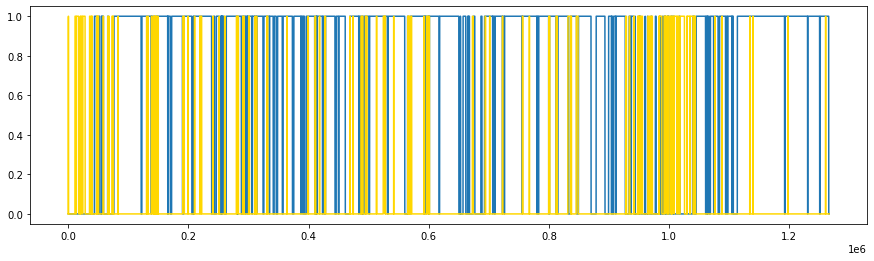

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(result.index, result['ADULT'])
plt.plot(result.index, result['CHILD'], color='gold')
plt.show()

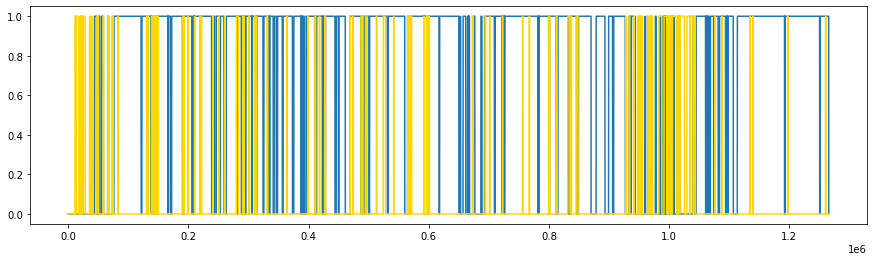

In [38]:
plt.figure(figsize=(15, 4))
plt.plot(result.index, result['SMOOTH_A'])
plt.plot(result.index, result['SMOOTH_C'], color='gold')
plt.show()

In [39]:
# Write output to CSV.
#result.to_csv('./TestData/eNY-0287.csv')

## TeacherPrint Data

In [40]:
def convert(n): 
    return time.strftime("%M min %S sec", time.gmtime(n))

### Summary

In [41]:
# Calculate the total time (sec).
tp_time = round(len(result.index)*.001,1)
print("TOTAL LESSON TIME: " + convert(tp_time)) 

TOTAL LESSON TIME: 21 min 06 sec


### Talk Time
#### Raw

In [42]:
# Calculate total talktime (sec).
tp_tt = round(((result['ADULT'].sum() + result['CHILD'].sum())*.001), 1)
print("TOTAL TALK TIME: " + convert(tp_tt)) 

# Calculate teacher talktime (sec and %).
tp_att = round(result['ADULT'].sum()*.001, 1)
tp_att_pc = int(round((tp_att/tp_tt)*100, 0))
print(tp_att, tp_att_pc)

# Calculate student talktime (sec and %).
tp_ctt = round(result['CHILD'].sum()*.001, 1)
tp_ctt_pc = int(round((tp_ctt/tp_tt)*100, 0))
print(tp_ctt, tp_ctt_pc)

print('During your lesson you spoke ' 
      + str(tp_att_pc) + '% of the time and the Students spoke ' 
      + str(tp_ctt_pc) + '% of the time.')

# Calculate the Talk Time metric ("For every second...".
tp_tt_metric = int(round(tp_att/tp_ctt, 0))

print('For every second of Student talk time, there were about ' 
      + str(tp_tt_metric) + ' seconds of Teacher talk time.')

TOTAL TALK TIME: 17 min 45 sec
937.2 88
128.1 12
During your lesson you spoke 88% of the time and the Students spoke 12% of the time.
For every second of Student talk time, there were about 7 seconds of Teacher talk time.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [43]:
# Calculate total smoothed talktime (sec).
tp_tt_s = round(((result['SMOOTH_A'].sum() + result['SMOOTH_C'].sum())*.001), 1)
print("TOTAL TALK TIME: " + convert(tp_tt_s)) 

# Calculate teacher talktime (sec and %).
tp_att_s = round(result['SMOOTH_A'].sum()*.001, 1)
tp_att_pc_s = int(round((tp_att_s/tp_tt_s)*100, 0))
print(tp_att_s, tp_att_pc_s)

# Calculate student talktime (sec and %).
tp_ctt_s = round(result['SMOOTH_C'].sum()*.001, 1)
tp_ctt_pc_s = int(round((tp_ctt_s/tp_tt_s)*100, 0))
print(tp_ctt_s, tp_ctt_pc_s)

print('During your lesson you spoke ' 
      + str(tp_att_pc_s) + '% of the time and the Students spoke ' 
      + str(tp_ctt_pc_s) + '% of the time.')

# Calculate the Talk Time metric ("For every second...".
tp_tt_metric_s = int(round(tp_att_s/tp_ctt_s, 0))

print('For every second of Student talk time, there were about ' 
      + str(tp_tt_metric_s) + ' seconds of Teacher talk time.')

TOTAL TALK TIME: 18 min 05 sec
948.8 87
137.0 13
During your lesson you spoke 87% of the time and the Students spoke 13% of the time.
For every second of Student talk time, there were about 7 seconds of Teacher talk time.


### Statements
#### Raw

In [28]:
#Calculate number of statements.
tp_utt_a = result['UTT_A'].value_counts()[1]
tp_utt_c = result['UTT_C'].value_counts()[1]
tp_utt = tp_utt_a + tp_utt_c
print("TOTAL STATEMENTS: " + str(tp_utt)) 
print(tp_utt_a, tp_utt_c)

# Calculate average statement length.
tp_uttlen_a = round((tp_att/tp_utt_a), 1)
tp_uttlen_c = round((tp_ctt/tp_utt_c), 1)

print('Your average statement was ' 
      + str(tp_uttlen_a) + ' seconds long, while the average Student statement was ' 
      + str(tp_uttlen_c) + ' seconds long.')

# Calculate the Statement metric ("For every second...".
tp_utt_metric = int(round(tp_uttlen_a/tp_uttlen_c, 0))

print('For every second of Student statements, there were about ' 
      + str(tp_utt_metric) + ' seconds of Teacher statements.')

TOTAL STATEMENTS: 234
120 114
Your average statement was 7.8 seconds long, while the average Student statement was 1.1 seconds long.
For every second of Student statements, there were about 7 seconds of Teacher statements.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [ ]:
#Calculate number of smoothed statements.
tp_utt_a_s = result['SMOOTH_UTT_A'].value_counts()[1]
tp_utt_c_s = result['SMOOTH_UTT_C'].value_counts()[1]
tp_utt_s = tp_utt_a_s + tp_utt_c_s
print("TOTAL STATEMENTS: " + str(tp_utt_s)) 
print(tp_utt_a_s, tp_utt_c_s)

# Calculate average smoothed statement length.
tp_uttlen_a_s = round((tp_att_s/tp_utt_a_s), 1)
tp_uttlen_c_s = round((tp_ctt_s/tp_utt_c_s), 1)

print('Your average statement was ' 
      + str(tp_uttlen_a_s) + ' seconds long, while the average Student statement was ' 
      + str(tp_uttlen_c_s) + ' seconds long.')


# Calculate the Statement metric ("For every second...".
tp_utt_metric_s = int(round(tp_uttlen_a_s/tp_uttlen_c_s, 0))

print('For every second of Student statements, there were about ' 
      + str(tp_utt_metric_s) + ' seconds of Teacher statements.')

### Pauses

#### Raw

In [ ]:
# Calculate pause time (sec).
tp_pt = round(result['PAUSE'].sum()*.001, 1)
tp_pt_avg = (round((tp_pt/tp_utt), 1))
print("TOTAL PAUSE TIME: " + convert(tp_pt)) 
print("AVERAGE PAUSE TIME: " + convert(tp_pt_avg)) 

#Calculate number of pauses.
tp_pause_a = result['UTT_A'].value_counts()[-1]
tp_pause_a_avg = (round((tp_pause_a/tp_utt_a), 1))
print(tp_pause_a, tp_pause_a_avg)

tp_pause_c = result['UTT_C'].value_counts()[-1]
tp_pause_c_avg = (round((tp_pause_c/tp_utt_c), 1))
print(tp_pause_c, tp_pause_c_avg)

tp_pause_c = result['UTT_S'].value_counts()[-1]
tp_pause_pc = int(round((tp_pause_c/tp_utt)*100, 0))
print(tp_pause_c, tp_pause_pc)

print('On average, the Students waited ' +
      str(tp_pause_a_avg) + ' seconds after you stopped speaking to begin their turn. You typically waited ' +
      str(tp_pause_c_avg) + ' seconds to speak after the Students stopped.')

print('In this lesson, ' + str(tp_pause_pc) 
      + '% of Statements had pauses between them.')

TOTAL PAUSE TIME: 03 min 57 sec
AVERAGE PAUSE TIME: 00 min 01 sec
120 1.0
114 1.0
156 67
On average, the Students waited 1.0 seconds after you stopped speaking to begin their turn. You typically waited 1.0 seconds to speak after the Students stopped.
In this lesson, 67% of Statements had pauses between them.


#### Smoothed

In [39]:
# Calculate pause time (sec).
tp_pt_s = round(result['SMOOTH_PAUSE'].sum()*.001, 1)
tp_pt_avg_s = (round((tp_pt_s/tp_utt_s), 1))
print("TOTAL PAUSE TIME: " + convert(tp_pt_s)) 
print("AVERAGE PAUSE TIME: " + convert(tp_pt_avg_s)) 

#Calculate number of pauses.
tp_pause_a_s = result['SMOOTH_UTT_A'].value_counts()[-1]
tp_pause_a_avg_s = (round((tp_pause_a_s/tp_utt_a_s), 1))
print(tp_pause_a_s, tp_pause_a_avg_s)

tp_pause_c_s = result['SMOOTH_UTT_C'].value_counts()[-1]
tp_pause_c_avg_s = (round((tp_pause_c_s/tp_utt_c_s), 1))
print(tp_pause_c_s, tp_pause_c_avg_s)

tp_pause_s = result['SMOOTH_UTT_S'].value_counts()[-1]
tp_pause_pc_s = int(round((tp_pause_s/tp_utt_s)*100, 0))
print(tp_pause_s, tp_pause_pc)

print('On average, the Students waited ' +
      str(tp_pause_a_avg_s) + ' seconds after you stopped speaking to begin their turn. You typically waited ' +
      str(tp_pause_c_avg_s) + ' seconds to speak after the Students stopped.')

print('In this lesson, ' + str(tp_pause_pc_s) 
      + '% of Statements had pauses between them.')

TOTAL PAUSE TIME: 03 min 42 sec
AVERAGE PAUSE TIME: 00 min 01 sec
117 1.0
110 1.0
144 67
On average, the Students waited 1.0 seconds after you stopped speaking to begin their turn. You typically waited 1.0 seconds to speak after the Students stopped.
In this lesson, 63% of Statements had pauses between them.


### Overlaps
Still need to figure out directionality.

#### Raw

In [29]:
# Calculate overlap time (sec).
tp_ot = round(result['OVERLAP'].sum()*.001, 1)
print("TOTAL OVERLAP TIME: " + convert(tp_ot)) 

tp_overlap_pc = 100 - tp_pause_pc
tp_ot_avg = round(tp_ot/(tp_overlap_pc*tp_utt), 3)

print('The average overlap was about ' + str(tp_ot_avg) + ' seconds.')

print('In this lesson ' + str(tp_overlap_pc) 
      + '% of Statements had overlaps between them.')

TOTAL OVERLAP TIME: 00 min 36 sec
The average overlap was about 0.005 seconds.
In this lesson 33% of Statements had overlaps between them.


#### Smoothed

In [30]:
# Calculate smoothed overlap time (sec).
tp_ot_s = round(result['SMOOTH_OVERLAP'].sum()*.001, 1)
print("TOTAL OVERLAP TIME: " + convert(tp_ot_s)) 

tp_overlap_pc_s = 100 - tp_pause_pc_s
tp_ot_avg_s = round(tp_ot_s/(tp_overlap_pc_s*tp_utt_s), 3)

print('The average overlap was about ' + str(tp_ot_avg_s) + ' seconds.')

print('In this lesson ' + str(tp_overlap_pc_s) 
      + '% of Statements had overlaps between them.')

TOTAL OVERLAP TIME: 00 min 41 sec
The average overlap was about 0.005 seconds.
In this lesson 37% of Statements had overlaps between them.


### Speaker Wheel
#### Raw

In [31]:
# Calculate Speaker Wheel input values (percent).
sw_adult = int(round((tp_att-tp_ot)/tp_time*100))
sw_overlap = int(round(tp_ot/tp_time*100))
sw_child = int(round((tp_ctt-tp_ot)/tp_time*100))
sw_pause = int(round(tp_pt/tp_time*100))
sw_df = {"TEACHER": sw_adult, "OVERLAPS": sw_overlap, "STUDENT": sw_child, "PAUSES": sw_pause}
sw_df

{'TEACHER': 71, 'OVERLAPS': 3, 'STUDENT': 7, 'PAUSES': 19}

#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [ ]:
# Calculate Speaker Wheel input values (percent) based on smoothed data.
sw_adult_s = int(round((tp_att_s-tp_ot_s)/tp_time*100))
sw_overlap_s = int(round(tp_ot_s/tp_time*100))
sw_child_s = int(round((tp_ctt_s-tp_ot_s)/tp_time*100))
sw_pause_s = int(round(tp_pt_s/tp_time*100))
sw_df_s = {"TEACHER": sw_adult, "OVERLAPS": sw_overlap, "STUDENT": sw_child, "PAUSES": sw_pause}
sw_df_s

## Troubleshooting statement counts

In [46]:
tshoot = RttmToUtteranceIndexedSpeakerActivity(DfFromRttm(file), outfile=None)

In [56]:
tshoot.head()

,START,DUR,LABEL,LABEL_NUM,DUR_TRANS,COUNT
0,0.041,0.289,CHILD,1,0.289,1
1,11.148,1.549,CHILD,1,1.549,1
3,13.492,3.827,CHILD,1,3.827,1
5,20.183,0.132,CHILD,1,0.132,1
6,20.993,2.255,CHILD,1,2.255,1


In [32]:
tot_lab_ct = 0
for lab in tshoot['LABEL'].unique():
    lab_ct = abs(tshoot[tshoot["LABEL"]==lab].sum()["LABEL_NUM"])
    print(f'There were {lab_ct} {lab} statements in the RTTM')
    tot_lab_ct += lab_ct
print(f'Total labels: {tot_lab_ct}')

There were 128 CHILD statements in the RTTM
There were 146 ADULT statements in the RTTM
Total labels: 274


In [ ]:
tshoot[tshoot["LABEL"]==lab].sum()

In [33]:
tshoot.where(tshoot["LABEL"]==lab).sum()["LABEL_NUM"]

-146.0

In [74]:
tshoot['START_ROUNDED'] = round(tshoot['START'], 4)

In [ ]:
len(tshoot['START'].unique()), len(tshoot['START_ROUNDED'].unique())
# tshoot[['START', 'START_ROUNDED']].head()

In [34]:
chiStartsRttm = tshoot[tshoot['LABEL']=='CHILD']['START_ROUNDED'] \
    .reset_index() \
    .rename(columns = {'START_ROUNDED': 'time_Rttm',
                      })
print(f'Rows: {len(chiStartsRttm)}')
chiStartsRttm.head(5)

Rows: 128


,index,time_Rttm
0,0,0.041
1,1,11.148
2,3,13.492
3,5,20.183
4,6,20.993


In [ ]:
chiStartsMSIndex = result[result['UTT_C']==1.0] \
    .reset_index()['millisecond_ints'] \
    .reset_index() \
    .rename(columns = {'millisecond_ints':'time_Results',
#                        'index': 'pos_Results'
                      })
print(f'Rows: {len(chiStartsMSIndex)}')
chiStartsMSIndex.head(5)

In [149]:
joined = pd.merge(left  = chiStartsRttm,
                  right = chiStartsMSIndex,
                  how   = 'outer')

In [35]:
len(joined)

193

In [ ]:
joined.head(40)